In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from transformers import BertModel, BertTokenizer

from sklearn.model_selection import train_test_split

In [ ]:
ProjectPath = './drive/My Drive/CSC2515 Final Project Part 1/'

In [ ]:
# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Read training data, test data left till achieving model parameters
X_train = pd.read_csv('./drive/My Drive/CSC2515 Final Project Part 1/train.csv')

# 1. Exploratory Data Analysis

In [ ]:
X_train.head()

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,4,"08 24, 2010",u04428712,"So is Katy Perry's new album ""Teenage Dream"" c...",Amazing that I Actually Bought This...More Ama...,1282608000,Pop,$35.93,p70761125,85559980,NaN
1,5,"10 31, 2009",u06946603,"I got this CD almost 10 years ago, and given t...",Excellent album,1256947200,Alternative Rock,$11.28,p85427891,41699565,NaN
2,4,"10 13, 2015",u92735614,I REALLY enjoy this pairing of Anderson and Po...,"Love the Music, Hate the Light Show",1444694400,Pop,$89.86,p82172532,24751194,NaN
3,5,"06 28, 2017",u35112935,Finally got it . It was everything thought it ...,Great,1498608000,Pop,$11.89,p15255251,22820631,NaN
4,4,"10 12, 2015",u07141505,"Look at all star cast. Outstanding record, pl...",Love these guys.,1444608000,Jazz,$15.24,p82618188,53377470,NaN


In [ ]:
# Store the length of training sample and global average rating
totalDatasetSize = len(X_train)
globalaverage = X_train['overall'].mean()

In [ ]:
# Compute the total number of reviewers and items in training set
reviewer = list(X_train['reviewerID'].unique())
item = list(X_train['itemID'].unique())

print('Reviewers: {}'.format(len(reviewer)))
print('Items: {}'.format(len(item)))
print('Train Set Length: {}'.format(len(X_train)))

Reviewers: 72285
Items: 25493
Train Set Length: 200000


## Distribution of Rating

In [ ]:
# Probe the ratings' distribution
# Check if there are decimals in the rating
ncls = X_train['overall'].nunique()
print('The rating score has: {}'.format(np.sort(X_train['overall'].unique())))

The rating score has: [1 2 3 4 5]


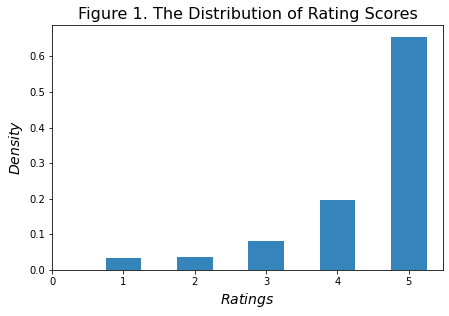

In [ ]:
# Compute and plot the empirical distribution of rating scores in the training set
ratings = X_train.groupby('overall')
ratings_weights = []

for i in range(ncls):
    ratings_weights.append(len(ratings.groups[i+1])/totalDatasetSize)
  
plt.figure(figsize=(7,4.5))
plt.hist(X_train['overall'], bins=np.arange(6) + 0.5, density=True, rwidth=0.5, alpha=0.9)
plt.title('Figure 1. The Distribution of Rating Scores', fontsize=16)
plt.xlabel('$Ratings$',fontsize=14)
plt.ylabel('$Density$',fontsize=14)
plt.xticks(range(6))
plt.show()

## Distribution of Review Text Length

In [ ]:
# Drop the rows without review texts for training model
index_train = [isinstance(X_train['reviewText'].iloc[i], str) for i in range(len(X_train))]
X_train_filtered = X_train[index_train]

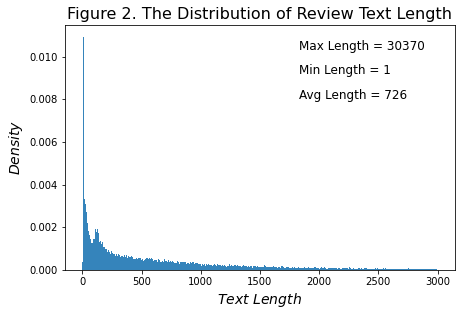

In [ ]:
# Check the distribution of review text length
textLength = list(map(len, X_train_filtered['reviewText']))

fig = plt.figure(figsize=(7,4.5))
ax = fig.add_subplot(111)

ax.annotate('Max Length = ' + str(int(np.max(textLength))), xy=(0.6,0.9), xycoords='axes fraction', fontsize=12)
ax.annotate('Min Length = ' + str(int(np.min(textLength))), xy=(0.6,0.8), xycoords='axes fraction', fontsize=12)
ax.annotate('Avg Length = ' + str(int(np.mean(textLength))), xy=(0.6,0.7), xycoords='axes fraction', fontsize=12)

ax.hist(textLength, bins=np.arange(3000), density=True, alpha=0.9)
plt.title('Figure 2. The Distribution of Review Text Length', fontsize=16)
plt.xlabel('${Text \ Length}$',fontsize=14)
plt.ylabel('$Density$',fontsize=14)
plt.show()

In [ ]:
X_train_filtered.loc[:, 'textLen'] = textLength

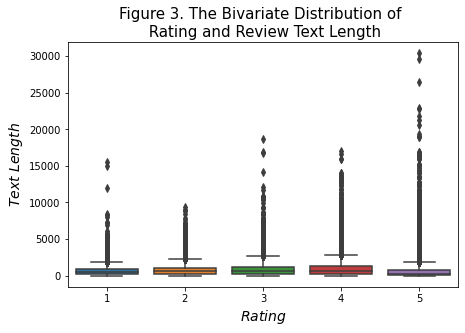

In [ ]:
fig = plt.figure(figsize=(7,4.5))
sns.boxplot(x='overall', y= 'textLen', data=X_train_filtered)
plt.title('Figure 3. The Bivariate Distribution of \n Rating and Review Text Length', fontsize=15)
plt.ylabel('${Text \ Length}$',fontsize=14)
plt.xlabel('$Rating$',fontsize=14)
plt.show()

# 2. Train BERT Classifier

In [ ]:
class ReviewsData(Dataset):
    def __init__(self, df, maxlen, test = False):
        self.df = df
        self.df.reset_index(drop=True, inplace=True)
        self.maxlen = maxlen
        self.test = test
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        reviewText = self.df.loc[index, 'reviewText']
        
        # Encode the BERT input through BERT tokenizer and set the max length for each sequence of text 
        tokens = self.tokenizer.tokenize(reviewText)
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for item in range(self.maxlen-len(tokens))]
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]']

        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids = torch.tensor(token_ids).long()

        attention_mask = (tokens_ids != 0).long()

        # If using test set, return corresponding indexes in the dataframe (instead of rating scores)
        if self.test == True:
            return tokens_ids, attention_mask, index

        ratings = int(self.df.loc[index, 'overall']) - 1
        
        return tokens_ids, attention_mask, ratings

In [ ]:
class RatingClassifier(nn.Module):
    def __init__(self, ncls, device):
        super(RatingClassifier, self).__init__()

        self.device = device

        # Pre-trained regular BERT layer (as opposed to enlarged BERT)
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')

        self.cls_layer = nn.Linear(768, ncls)  

    def forward(self, seq, am):
        # Feeding the sequences to the BERT layer
        res = self.bert_layer(seq, attention_mask = am)

        # Obtain the encoded results for '[CLS]'
        cont_reps = res[0]
        cls_rep = cont_reps[:,0,:]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits.to(self.device)

In [ ]:
def train(net, loss_func, opti, train_loader, val_loader, max_len, epochs):
    best_acc = 0
    
    for ep in range(epochs):
        print('Epoch: {}'.format(ep+1))
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            opti.zero_grad()
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

            logits = net(seq, attn_masks)
            loss = loss_func(m(logits), labels)

            loss.backward()
            opti.step()

            # Print loss and save model for every 500 batches
            if (it + 1) % 500 == 0:
                predicted = logits.max(dim = 1)[1]
                acc = (predicted == labels).float().mean()
                print('Iteration {} Loss : {}, Accuracy : {}'.format(it+1, loss.item(), acc))
                
                if not os.path.exists(os.path.join(ProjectPath, 'Results')):
                    os.makedirs(os.path.join(ProjectPath, 'Results'))

                torch.save(net.state_dict(), os.path.join(ProjectPath, 'Results', 'ClassifierModel_'+str(max_len)+'_'+str(epochs)))
                print("Saving at", os.path.join(ProjectPath, 'Results', 'ClassifierModel_'+str(max_len)+'_'+str(epochs)))

        # perform validation at the end of an epoch.
        val_acc, val_loss = evaluate(net, loss_func, val_loader)
        print('Validation Accuracy : {}, Validation Loss : {}'.format(val_acc, val_loss))

        if val_acc > best_acc:
            print('Best validation accuracy improved from {} to {}, saving model... \n'.format(best_acc, val_acc))
            best_acc = val_acc
            torch.save(net.state_dict(), os.path.join(ProjectPath, 'Results', 'ClassifierModel_'+str(max_len)+'_'+str(epochs) + '_valSet_' + str(best_acc)))

In [ ]:
def evaluate(net, loss_func, dataloader):
    net.eval()

    acc, loss, count = 0, 0, 0

    with torch.no_grad():
        for seq, attn_masks, labels in dataloader:
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

            logits = net(seq, attn_masks)
            predicted = logits.max(dim = 1)[1]
            acc += (predicted == labels).float().mean()
            loss += loss_func(m(logits), labels) 
            
            #print("Validation iteration", count+1)
            count += 1

            if count > 0.2 * len(dataloader):
                print("Validation iteration", count+1)
                break

    mean_acc = acc/count
    mean_loss = loss/count

    return mean_acc, mean_loss

## Load Data

In [ ]:
len_lst = [100, 200, 300, 512]
epochs = [2, 3, 4]

In [ ]:
# 20% of training data used for validation
train_set, val_set = train_test_split(X_train_filtered, test_size=0.2, random_state=42)

In [ ]:
max_text = len_lst[1]
train_loader = ReviewsData(train_set, max_text)
val_loader = ReviewsData(val_set, max_text)

train_loader = DataLoader(train_loader, batch_size = 64, num_workers = 4)
val_loader = DataLoader(val_loader, batch_size = 64, num_workers = 4)

## Set Parameters

In [ ]:
net = RatingClassifier(ncls, device)
net.to(device)

weights = torch.tensor(ratings_weights).to(device)

In [ ]:
loss_func = nn.NLLLoss(weight=weights)
opti = optim.Adam(net.parameters(), lr = 2e-5)
m = nn.LogSoftmax(dim=1)

## Fine-tune the Model

In [ ]:
# 1: max_text = 100, epochs = 3, using all training sample
torch.cuda.set_device(0)
train(net, loss_func, opti, train_loader, val_loader, max_text, epochs[1])

Epoch: 1
Iteration 500 Loss : 0.4074399769306183, Accuracy : 0.625
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_100_3
Iteration 1000 Loss : 0.3531838357448578, Accuracy : 0.59375
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_100_3
Iteration 1500 Loss : 0.3445776402950287, Accuracy : 0.609375
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_100_3
Iteration 2000 Loss : 0.30966436862945557, Accuracy : 0.671875
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_100_3
Iteration 2500 Loss : 0.31352537870407104, Accuracy : 0.6571428775787354
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_100_3
Validation iteration 201
Validation Accuracy : 0.6935155987739563, Validation Loss : 0.29043716192245483
Best validation accuracy improved from 0 to 0.6935155987739563, saving model... 

Epoch: 2
Iteration 500 Loss : 0.3255575895309448, Accurac

In [ ]:
# 2: max_text = 200, epochs = 2, using all training sample
torch.cuda.set_device(0)
train(net, loss_func, opti, train_loader, val_loader, max_text[1], epochs[0])

Epoch: 1
Iteration 500 Loss : 0.371735543012619, Accuracy : 0.671875
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_200_2
Iteration 1000 Loss : 0.3188224732875824, Accuracy : 0.609375
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_200_2
Iteration 1500 Loss : 0.36448097229003906, Accuracy : 0.59375
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_200_2
Iteration 2000 Loss : 0.2820305824279785, Accuracy : 0.734375
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_200_2
Iteration 2500 Loss : 0.32007136940956116, Accuracy : 0.7428571581840515
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_200_2
Validation iteration 201
Validation Accuracy : 0.7113280892372131, Validation Loss : 0.27381831407546997
Best validation accuracy improved from 0 to 0.7113280892372131, saving model... 

Epoch: 2
Iteration 500 Loss : 0.2704688012599945, Accur

In [ ]:
X_train_filtered_sampled = X_train_filtered.sample(n=50000, random_state=42)
train_set_sampled, val_set_sampled = train_test_split(X_train_filtered_sampled, test_size=0.2, random_state=42)

In [ ]:
max_text = len_lst[2]
train_loader_sampled = ReviewsData(train_set_sampled, max_text)
val_loader_sampled = ReviewsData(val_set_sampled, max_text)

train_loader_sampled = DataLoader(train_loader_sampled, batch_size = 32, num_workers = 4)
val_loader_sampled = DataLoader(val_loader_sampled, batch_size = 32, num_workers = 4)

In [ ]:
# 3: max_text = 300, epochs = 2, sampling 20% from traing set and using smaller batchsize (=32)
torch.cuda.set_device(0)
train(net, loss_func, opti, train_loader_sampled, val_loader_sampled, max_text[2], epochs[0])

Epoch: 1
Iteration 500 Loss : 0.4792402386665344, Accuracy : 0.46875
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_300_2
Iteration 1000 Loss : 0.23866459727287292, Accuracy : 0.78125
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_300_2
Validation iteration 64
Validation Accuracy : 0.7068452835083008, Validation Loss : 0.27850446105003357
Best validation accuracy improved from 0 to 0.7068452835083008, saving model... 

Epoch: 2
Iteration 500 Loss : 0.3150264620780945, Accuracy : 0.5625
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_300_2
Iteration 1000 Loss : 0.23440569639205933, Accuracy : 0.8125
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_300_2
Validation iteration 64
Validation Accuracy : 0.7197421193122864, Validation Loss : 0.3096318244934082
Best validation accuracy improved from 0.7068452835083008 to 0.7197421193122864, saving model... 



In [ ]:
# 4: max_text = 512, epochs = 2, sampling 20% from traing set and using smaller batchsize (=16)
torch.cuda.set_device(0)
train(net, loss_func, opti, train_loader_sampled, val_loader_sampled, max_text[4], epochs[0])

Epoch: 1
Iteration 500 Loss : 0.4931972622871399, Accuracy : 0.6875
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_512_2
Iteration 1000 Loss : 0.3323201537132263, Accuracy : 0.5625
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_512_2
Iteration 1500 Loss : 0.22397346794605255, Accuracy : 0.75
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_512_2
Iteration 2000 Loss : 0.20504611730575562, Accuracy : 0.8125
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_512_2
Iteration 2500 Loss : 0.5082453489303589, Accuracy : 0.4375
Saving at ./drive/My Drive/CSC2515 Final Project Part 1/Results/ClassifierModel_512_2
Validation iteration 5
Validation Accuracy : 0.8125, Validation Loss : 0.227868914604187
Best validation accuracy improved from 0 to 0.8125, saving model... 

Epoch: 2
Iteration 500 Loss : 0.38186120986938477, Accuracy : 0.75
Saving at ./drive/My Drive/CSC2515 F

# 3. Recover from Training Results

In [ ]:
# Recover the trained model from saved parameters
net = RatingClassifier(ncls, device)
net.to(device)
net.load_state_dict(torch.load(ProjectPath+'/Results/ClassifierModel'))

<All keys matched successfully>

# 4. Run Test Cases

In [ ]:
X_test = pd.read_csv('./drive/My Drive/CSC2515 Final Project Part 1/test.csv')

In [ ]:
# Filter the row without review texts from the original test set
# Store the row number in 'Check'
Check = [i for i in range(10000) if not isinstance(X_test['reviewText'].iloc[i], str)]
X_test = X_test[[isinstance(X_test['reviewText'].iloc[i], str) for i in range(10000)]]

In [ ]:
X_test.shape

(9999, 10)

In [ ]:
# Loading test data
test_set = ReviewsData(X_test, max_text, test=True)
test_loader = DataLoader(test_set, batch_size = 8, num_workers = 4)

In [ ]:
# Predict test rating
index_list = []
predicted_list = []

for it, (seq, attn_masks, indexes) in enumerate(test_loader):
    seq, attn_masks, indexes = seq.to(device), attn_masks.to(device), indexes
    logit = net(seq, attn_masks)
    predicted = logit.max(dim = 1)[1]
    index_list.append(indexes)
    predicted_list.append(predicted)

In [ ]:
# Matching the predicting results with test dataframe 
results = []
for i in predicted_list:
    results += i.tolist()

results = np.array(results)

# Plus 1 on the prediction
X_test['overall'] = results+1

In [ ]:
X_test.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image,overall
0,"03 26, 2015",u32476110,"Fantastic mix of ""old school"" with a creative ...","Fantastic mix of ""old school"" with a creative ...",1427328000,Pop,$14.98,p76243483,20167847,NaN,5
1,"05 15, 2017",u36732410,Update: Indications\nThere are various opinion...,Digitally Extracted Stereo (DES) Rules!,1494806400,Pop,$15.16,p92485419,30527605,NaN,5
2,"06 4, 2015",u85385007,This album provides a new twist on old Sammy H...,Excellent unplugged album,1433376000,Pop,$7.37,p40031588,12169432,NaN,5
3,"04 23, 2009",u30715529,(Symbol) can be considered as another masterpi...,another masterpiece,1240444800,Pop,$12.45,p88719785,55648615,NaN,5
4,"09 15, 2000",u95909892,Many would think this album is good only becau...,True Classic Rock,968976000,Alternative Rock,$2.07,p59188380,9520938,NaN,5


In [ ]:
#X_test.to_csv(ProjectPath+'/test_results_'+str(max_text[4])+'_'+str(epochs[0])+'.csv', index=None)

# 5. Match the Ratings with the Rating Pairs

In [ ]:
rating_pairs = pd.read_csv(ProjectPath+'rating_pairs.csv')
rating_pairs.head()

,userID-itemID,prediction
0,u32476110-p76243483,NaN
1,u36732410-p92485419,NaN
2,u85385007-p40031588,NaN
3,u30715529-p88719785,NaN
4,u95909892-p59188380,NaN


In [ ]:
X_test['userID-itemID'] = X_test['reviewerID'].str.cat(X_test['itemID'], sep = '-')

In [ ]:
# Mapping
rating_pairs = pd.merge(rating_pairs, X_test[['userID-itemID', 'overall']], how = 'left', on = 'userID-itemID').drop(['prediction'], axis=1)
rating_pairs.columns=['userID-itemID','prediction']

In [ ]:
rating_pairs.loc[Check,:]

,userID-itemID,prediction
7628,u18947357-p52207057,NaN


In [ ]:
# Set the exception row with the global average
rating_pairs.loc[Check,'prediction'] = int(globalaverage)

In [ ]:
rating_pairs.to_csv(ProjectPath+'rating_pairs_results_'+str(max_text)+'_'+str(epochs[0])+'.csv', index=None)